### Problem Statement

The largest and fastest-growing fully integrated player in India's logistics sector by revenue in Fiscal 2021 aims to build the operating system for commerce. This ambition is driven by their commitment to world-class infrastructure, superior logistics operations, and cutting-edge engineering and technology capabilities. The Data team plays a pivotal role by leveraging data to enhance the quality, efficiency, and profitability of the business, setting it apart from competitors.

To achieve these objectives, the company needs to process and understand the vast amounts of data generated from its data engineering pipelines. The tasks involved include:

1. **Data Cleaning and Sanitization**: Raw data collected from various sources often contains noise, missing values, and inconsistencies. The first step is to clean and sanitize this data to ensure its quality and reliability.

2. **Feature Engineering**: Transforming raw data into meaningful features is crucial for building effective models. This step involves manipulating and extracting useful information from raw fields, which can be used as input for machine learning models.

3. **Data Analysis and Interpretation**: Understanding the patterns, trends, and insights within the raw data is essential. This involves exploratory data analysis (EDA) to uncover hidden patterns and relationships.

4. **Forecasting Model Development**: Using the processed and engineered features, the data science team aims to build robust forecasting models. These models will help in predicting future trends, demands, and other key metrics that drive business decisions.

The goal is to develop a comprehensive approach that addresses the following key aspects:

- **Data Cleaning**: Removing noise, handling missing values, and correcting inconsistencies in the data.
- **Feature Engineering**: Creating new features and transforming existing ones to improve model performance.
- **Exploratory Data Analysis**: Gaining insights from the data through visualization and statistical analysis.
- **Forecasting**: Developing and validating predictive models to forecast future trends and metrics.

By addressing these tasks, the company aims to leverage data to drive strategic decisions, optimize operations, and maintain its competitive edge in the logistics industry. This project will involve a series of steps including data preprocessing, feature extraction, exploratory analysis, and model building, all aimed at transforming raw data into actionable insights and accurate forecasts.

### Data Dictionary

This data dictionary provides detailed descriptions of the fields present in the dataset.

| **Field Name**                | **Description**                                                                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| **data**                      | Indicates whether the data is for testing or training purposes.                                                                                       |
| **trip_creation_time**        | Timestamp of when the trip was created.                                                                                                               |
| **route_schedule_uuid**       | Unique identifier for a particular route schedule.                                                                                                   |
| **route_type**                | Type of transportation used.                                                                                                                          |
| **FTL**                       | Full Truck Load: Shipments that get to the destination sooner as the truck makes no other pickups or drop-offs along the way.                          |
| **Carting**                   | Handling system consisting of small vehicles (carts).                                                                                                 |
| **trip_uuid**                 | Unique ID given to a particular trip (A trip may include different source and destination centers).                                                   |
| **source_center**             | Source ID of trip origin.                                                                                                                             |
| **source_name**               | Source Name of trip origin.                                                                                                                           |
| **destination_center**        | Destination ID of trip.                                                                                                                               |
| **destination_name**          | Destination Name of trip.                                                                                                                             |
| **od_start_time**             | Trip start time.                                                                                                                                      |
| **od_end_time**               | Trip end time.                                                                                                                                        |
| **start_scan_to_end_scan**    | Time taken to deliver from source to destination.                                                                                                     |
| **is_cutoff**                 | Unknown field.                                                                                                                                        |
| **cutoff_factor**             | Unknown field.                                                                                                                                        |
| **cutoff_timestamp**          | Unknown field.                                                                                                                                        |
| **actual_distance_to_destination** | Distance in kilometers between the source and destination warehouse.                                                                          |
| **actual_time**               | Actual time taken to complete the delivery (cumulative).                                                                                              |
| **osrm_time**                 | Time calculated by an open-source routing engine, which computes the shortest path between points in a given map (includes usual traffic and distance) (cumulative). |
| **osrm_distance**             | Distance calculated by an open-source routing engine, which computes the shortest path between points in a given map (includes usual traffic and distance) (cumulative). |
| **factor**                    | Unknown field.                                                                                                                                        |
| **segment_actual_time**       | Time taken by a segment (subset) of the package delivery.                                                                                            |
| **segment_osrm_time**         | OSRM segment time, which is the time taken by a segment (subset) of the package delivery, as calculated by the open-source routing engine.             |
| **segment_osrm_distance**     | OSRM segment distance, which is the distance covered by a segment (subset) of the package delivery, as calculated by the open-source routing engine.   |
| **segment_factor**            | Unknown field.                                                                                                                                        |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('logistics_data.txt')

- Removing null values

In [3]:
df = df.dropna(how='any')
df = df.reset_index(drop=True)

- Converting time columns into pandas datatime

In [4]:
df['od_start_time'] =  pd.to_datetime(df['od_start_time'])
df['od_end_time']  =  pd.to_datetime(df['od_end_time'])

In [5]:
df.head(5)

data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                 source_name  \
0  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
3  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   
4  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   

  destination_center               destination_name  \
0       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
1       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
2       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
3       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   
4       IND388620AAB  Khambhat_MotvdDPP_D (Gujarat)   

               od_start_time  ...            cutoff_timestamp  \
0 2018-09-20 03:21:32.418600  ...         2018-09-20 04:27:55   
1 2018-09-20 03:21:32.418600  ...         2018-09-20 04:17:55   
2 2018-09-20 03:21:32.418600  ...  2018-09-20 04:01:19.505586   
3 2018-09-20 03:21:32.418600  ...         2018-09-20 03:39:57   
4 2018-09-20 03:21:32.418600  ...         2018-09-20 03:33:55   

   actual_distance_to_destination  actual_time  osrm_time osrm_distance  \
0                       10.435660         14.0       11.0       11.9653   
1                       18.936842         24.0       20.0       21.7243   
2                       27.637279         40.0       28.0       32.5395   
3                       36.118028         62.0       40.0       45.5620   
4                       39.386040         68.0       44.0       54.2181   

     factor  segment_actual_time  segment_osrm_time  segment_osrm_distance  \
0  1.272727                 14.0               11.0                11.9653   
1  1.200000                 10.0                9.0                 9.7590   
2  1.428571                 16.0                7.0                10.8152   
3  1.550000                 21.0               12.0                13.0224   
4  1.545455                  6.0                5.0                 3.9153   

   segment_factor  
0        1.272727  
1        1.111111  
2        2.285714  
3        1.750000  
4        1.200000  

[5 rows x 24 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144316 entries, 0 to 144315
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144316 non-null  object        
 1   trip_creation_time              144316 non-null  object        
 2   route_schedule_uuid             144316 non-null  object        
 3   route_type                      144316 non-null  object        
 4   trip_uuid                       144316 non-null  object        
 5   source_center                   144316 non-null  object        
 6   source_name                     144316 non-null  object        
 7   destination_center              144316 non-null  object        
 8   destination_name                144316 non-null  object        
 9   od_start_time                   144316 non-null  datetime64[ns]
 10  od_end_time                     144316 non-null  datetim

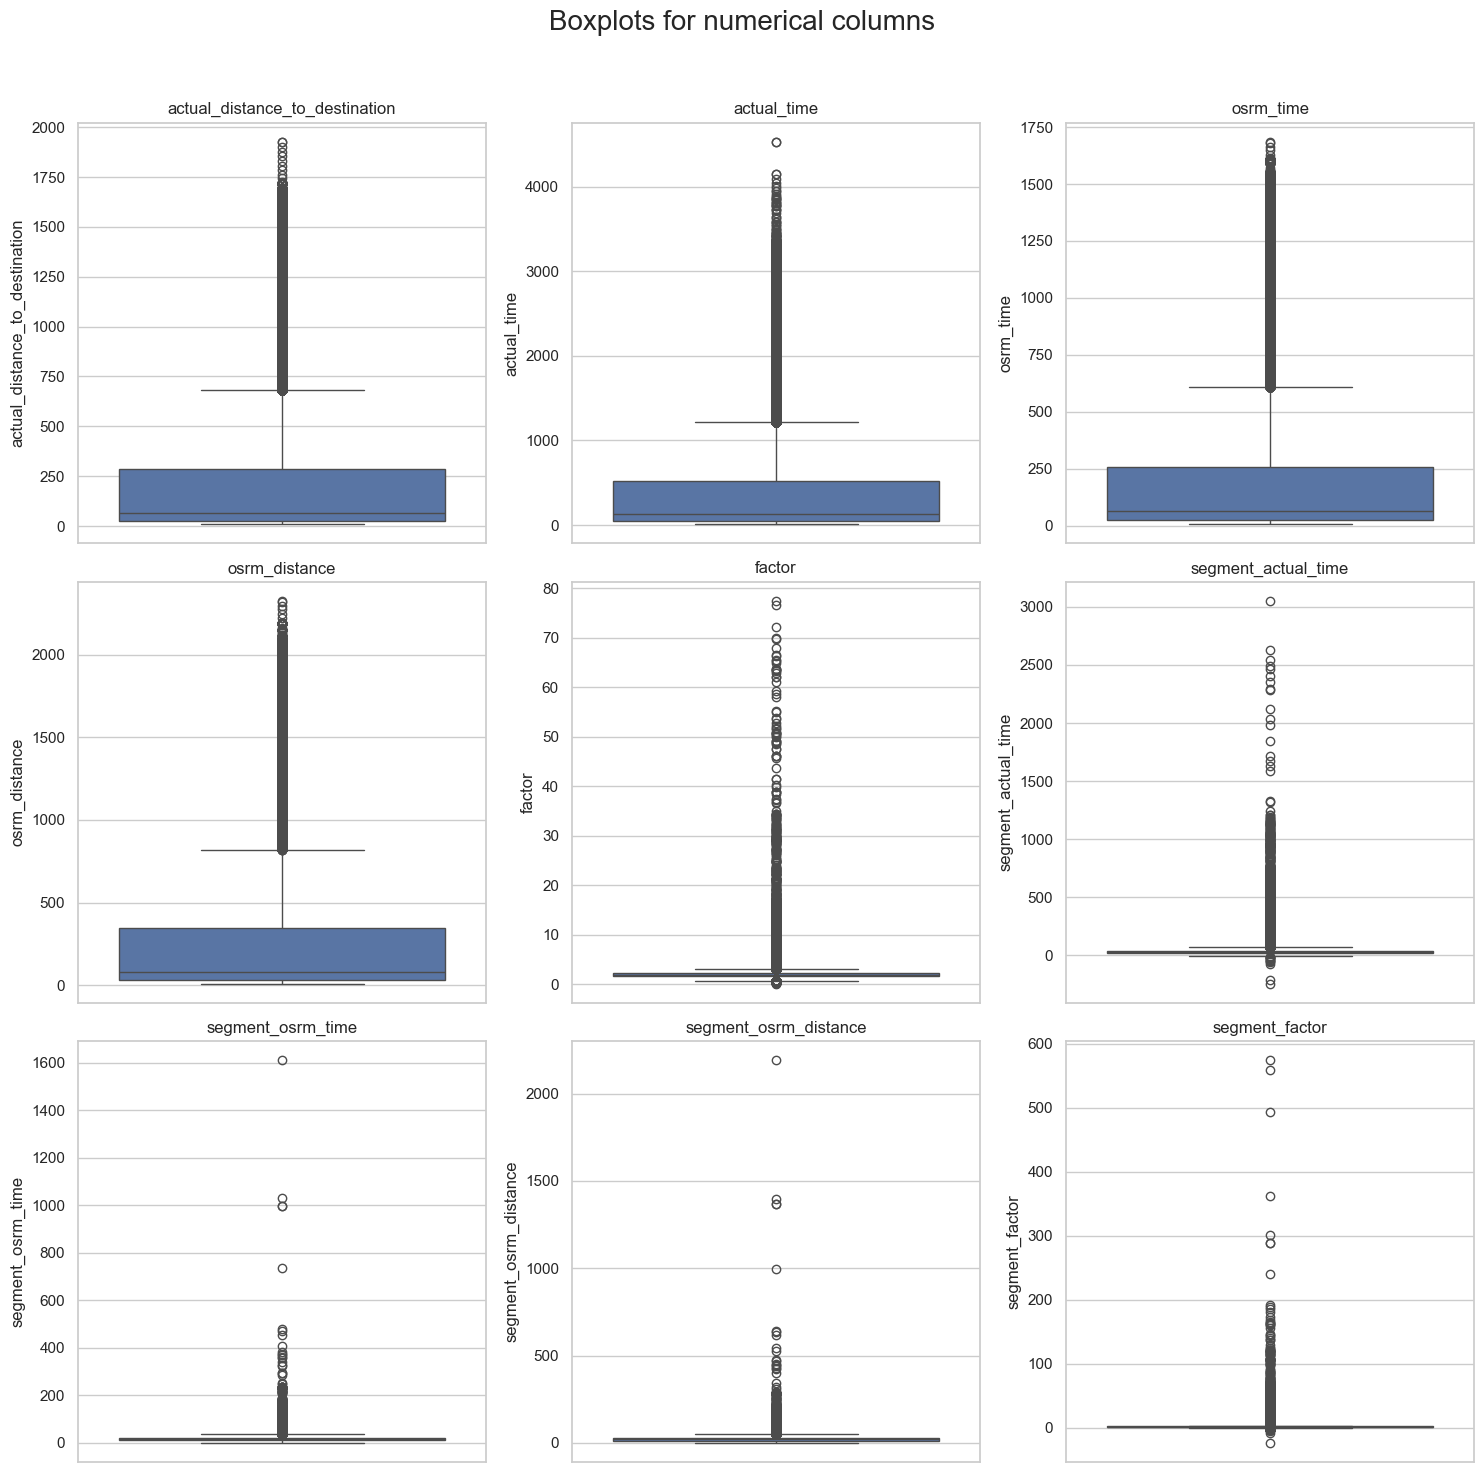

In [10]:
columns = [
    "actual_distance_to_destination", 
    "actual_time", 
    "osrm_time", 
    "osrm_distance", 
    "factor", 
    "segment_actual_time", 
    "segment_osrm_time", 
    "segment_osrm_distance", 
    "segment_factor"
]

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Boxplots for numerical columns', fontsize=20)

axes = axes.flatten()

for i, column in enumerate(columns):
    sns.boxplot(data=df[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

- Grouping by sub-journey in the trip

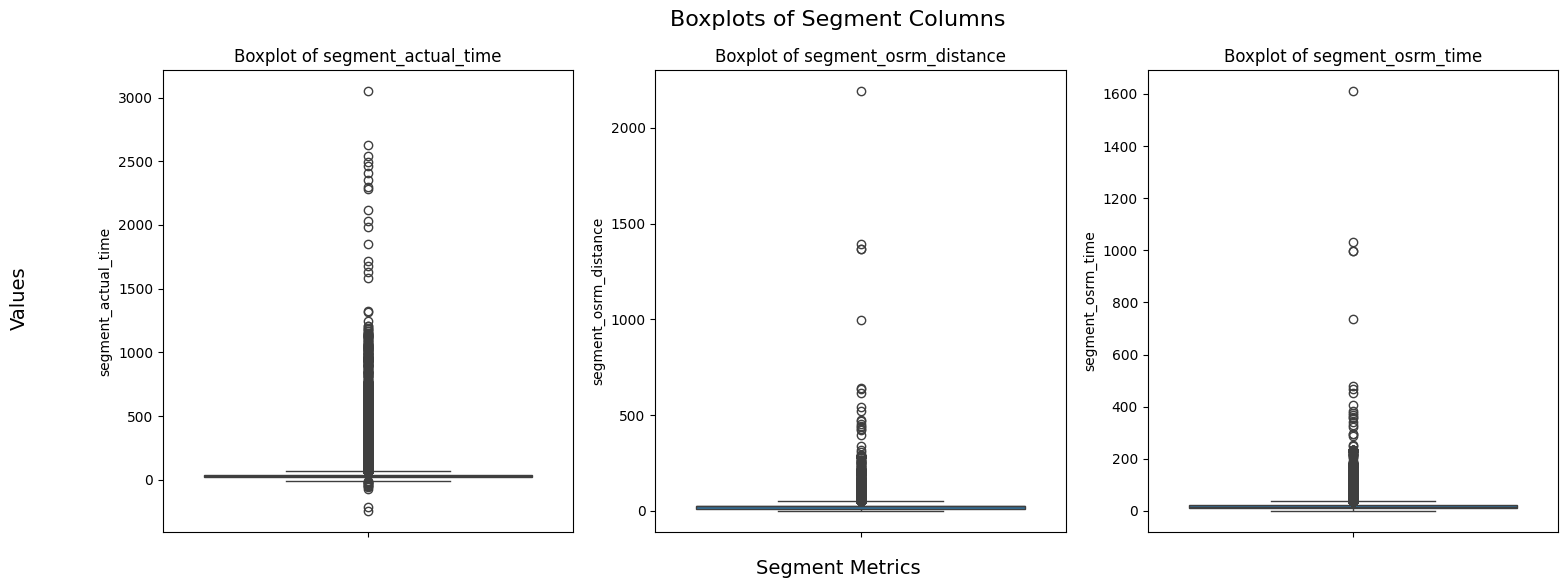

segment_key  \
0       trip-153741093647649320IND388121AAAIND388620AAB   
1       trip-153741093647649320IND388121AAAIND388620AAB   
2       trip-153741093647649320IND388121AAAIND388620AAB   
3       trip-153741093647649320IND388121AAAIND388620AAB   
4       trip-153741093647649320IND388121AAAIND388620AAB   
...                                                 ...   
144311  trip-153746066843555182IND131028AABIND000000ACB   
144312  trip-153746066843555182IND131028AABIND000000ACB   
144313  trip-153746066843555182IND131028AABIND000000ACB   
144314  trip-153746066843555182IND131028AABIND000000ACB   
144315  trip-153746066843555182IND131028AABIND000000ACB   

        segment_actual_time_sum  segment_osrm_distance_sum  \
0                          14.0                    11.9653   
1                          24.0                    21.7243   
2                          40.0                    32.5395   
3                          61.0                    45.5619   
4                          67.0                    49.4772   
...                         ...                        ...   
144311                     92.0                    65.3487   
144312                    118.0                    82.7212   
144313                    138.0                   103.4265   
144314                    155.0                   122.3150   
144315                    423.0                   131.1238   

        segment_osrm_time_sum  
0                        11.0  
1                        20.0  
2                        27.0  
3                        39.0  
4                        44.0  
...                       ...  
144311                   94.0  
144312                  115.0  
144313                  149.0  
144314                  176.0  
144315                  185.0  

[144316 rows x 4 columns]

In [7]:
df['segment_key'] = df['trip_uuid'] + df['source_center'] + df['destination_center']

segment_cols = ['segment_actual_time', 'segment_osrm_distance', 'segment_osrm_time']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, col in zip(axes, segment_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('')

fig.text(0.5, 0.04, 'Segment Metrics', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical', fontsize=14)

plt.suptitle('Boxplots of Segment Columns', fontsize=16)
plt.show()

for col in segment_cols:
    df[col + '_sum'] = df.groupby('segment_key')[col].cumsum()


df[['segment_key']+[col + '_sum' for col in segment_cols]]

- aggregating at sub-journey level

In [8]:
create_segment_dict = {

    'data' : 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',
    'source_center' : 'first',
    'source_name' : 'first',

    'destination_center' : 'last',
    'destination_name' : 'last',

    'od_start_time' : 'first',
    'od_end_time' : 'first',
    'start_scan_to_end_scan' : 'first',


    'actual_distance_to_destination' : 'last',
    'actual_time' : 'last',

    'osrm_time' : 'last',
    'osrm_distance' : 'last',

    'segment_actual_time_sum' : 'last',
    'segment_osrm_distance_sum' : 'last',
    'segment_osrm_time_sum' : 'last',

    }

- Groupby mini-trips, sorting by time

In [9]:
segment = df.groupby('segment_key').agg(create_segment_dict).reset_index()
segment = segment.sort_values(by=['segment_key','od_end_time'], ascending=True).reset_index()

In [10]:
segment

index                                      segment_key      data  \
0          0  trip-153671041653548748IND209304AAAIND000000ACB  training   
1          1  trip-153671041653548748IND462022AAAIND209304AAA  training   
2          2  trip-153671042288605164IND561203AABIND562101AAA  training   
3          3  trip-153671042288605164IND572101AAAIND561203AAB  training   
4          4  trip-153671043369099517IND000000ACBIND160002AAC  training   
...      ...                                              ...       ...   
26217  26217  trip-153861115439069069IND628204AAAIND627657AAA      test   
26218  26218  trip-153861115439069069IND628613AAAIND627005AAA      test   
26219  26219  trip-153861115439069069IND628801AAAIND628204AAA      test   
26220  26220  trip-153861118270144424IND583119AAAIND583101AAA      test   
26221  26221  trip-153861118270144424IND583201AAAIND583119AAA      test   

               trip_creation_time  \
0      2018-09-12 00:00:16.535741   
1      2018-09-12 00:00:16.535741   
2      2018-09-12 00:00:22.886430   
3      2018-09-12 00:00:22.886430   
4      2018-09-12 00:00:33.691250   
...                           ...   
26217  2018-10-03 23:59:14.390954   
26218  2018-10-03 23:59:14.390954   
26219  2018-10-03 23:59:14.390954   
26220  2018-10-03 23:59:42.701692   
26221  2018-10-03 23:59:42.701692   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
2      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
3      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
4      thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
...                                                  ...        ...   
26217  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26218  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26219  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26220  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   
26221  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   

                     trip_uuid source_center  \
0      trip-153671041653548748  IND209304AAA   
1      trip-153671041653548748  IND462022AAA   
2      trip-153671042288605164  IND561203AAB   
3      trip-153671042288605164  IND572101AAA   
4      trip-153671043369099517  IND000000ACB   
...                        ...           ...   
26217  trip-153861115439069069  IND628204AAA   
26218  trip-153861115439069069  IND628613AAA   
26219  trip-153861115439069069  IND628801AAA   
26220  trip-153861118270144424  IND583119AAA   
26221  trip-153861118270144424  IND583201AAA   

                              source_name destination_center  ...  \
0      Kanpur_Central_H_6 (Uttar Pradesh)       IND000000ACB  ...   
1      Bhopal_Trnsport_H (Madhya Pradesh)       IND209304AAA  ...   
2       Doddablpur_ChikaDPP_D (Karnataka)       IND562101AAA  ...   
3           Tumkur_Veersagr_I (Karnataka)       IND561203AAB  ...   
4           Gurgaon_Bilaspur_HB (Haryana)       IND160002AAC  ...   
...                                   ...                ...  ...   
26217  Tirchchndr_Shnmgprm_D (Tamil Nadu)       IND627657AAA  ...   
26218   Peikulam_SriVnktpm_D (Tamil Nadu)       IND627005AAA  ...   
26219        Eral_Busstand_D (Tamil Nadu)       IND628204AAA  ...   
26220       Sandur_WrdN1DPP_D (Karnataka)       IND583101AAA  ...   
26221                  Hospet (Karnataka)       IND583119AAA  ...   

                   od_start_time                od_end_time  \
0     2018-09-12 16:39:46.858469 2018-09-13 13:40:23.123744   
1     2018-09-12 00:00:16.535741 2018-09-12 16:39:46.858469   
2     2018-09-12 02:03:09.655591 2018-09-12 03:01:59.598855   
3     2018-09-12 00:00:22.886430 2018-09-12 02:03:09.655591   
4     2018-09-14 03:40:17.106733 2018-09-14 17:34:55.442454   
...                     

In [11]:
segment[segment['trip_uuid'] == 'trip-153671041653548748']

index                                      segment_key      data  \
0      0  trip-153671041653548748IND209304AAAIND000000ACB  training   
1      1  trip-153671041653548748IND462022AAAIND209304AAA  training   

           trip_creation_time  \
0  2018-09-12 00:00:16.535741   
1  2018-09-12 00:00:16.535741   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   

                 trip_uuid source_center                         source_name  \
0  trip-153671041653548748  IND209304AAA  Kanpur_Central_H_6 (Uttar Pradesh)   
1  trip-153671041653548748  IND462022AAA  Bhopal_Trnsport_H (Madhya Pradesh)   

  destination_center  ...              od_start_time  \
0       IND000000ACB  ... 2018-09-12 16:39:46.858469   
1       IND209304AAA  ... 2018-09-12 00:00:16.535741   

                 od_end_time start_scan_to_end_scan  \
0 2018-09-13 13:40:23.123744                 1260.0   
1 2018-09-12 16:39:46.858469                  999.0   

   actual_distance_to_destination  actual_time  osrm_time  osrm_distance  \
0                      383.759164        732.0      329.0       446.5496   
1                      440.973689        830.0      388.0       544.8027   

   segment_actual_time_sum  segment_osrm_distance_sum  segment_osrm_time_sum  
0                    728.0                   670.6205                  534.0  
1                    820.0                   649.8528                  474.0  

[2 rows x 21 columns]

In [12]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26222 entries, 0 to 26221
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           26222 non-null  int64         
 1   segment_key                     26222 non-null  object        
 2   data                            26222 non-null  object        
 3   trip_creation_time              26222 non-null  object        
 4   route_schedule_uuid             26222 non-null  object        
 5   route_type                      26222 non-null  object        
 6   trip_uuid                       26222 non-null  object        
 7   source_center                   26222 non-null  object        
 8   source_name                     26222 non-null  object        
 9   destination_center              26222 non-null  object        
 10  destination_name                26222 non-null  object        
 11  od

### Calculate time taken between od_start_time and od_end_time and keep it as a feature. `

- od_time_diff_hour is matching with start_scan_to_end_scan

In [13]:
segment['od_time_diff_hour'] = (segment['od_end_time'] - segment['od_start_time']).dt.total_seconds() / (60)
segment['od_time_diff_hour']

0        1260.604421
1         999.505379
2          58.832388
3         122.779486
4         834.638929
            ...     
26217      62.115193
26218      91.087797
26219      44.174403
26220     287.474007
26221      66.933565
Name: od_time_diff_hour, Length: 26222, dtype: float64

In [14]:
segment

index                                      segment_key      data  \
0          0  trip-153671041653548748IND209304AAAIND000000ACB  training   
1          1  trip-153671041653548748IND462022AAAIND209304AAA  training   
2          2  trip-153671042288605164IND561203AABIND562101AAA  training   
3          3  trip-153671042288605164IND572101AAAIND561203AAB  training   
4          4  trip-153671043369099517IND000000ACBIND160002AAC  training   
...      ...                                              ...       ...   
26217  26217  trip-153861115439069069IND628204AAAIND627657AAA      test   
26218  26218  trip-153861115439069069IND628613AAAIND627005AAA      test   
26219  26219  trip-153861115439069069IND628801AAAIND628204AAA      test   
26220  26220  trip-153861118270144424IND583119AAAIND583101AAA      test   
26221  26221  trip-153861118270144424IND583201AAAIND583119AAA      test   

               trip_creation_time  \
0      2018-09-12 00:00:16.535741   
1      2018-09-12 00:00:16.535741   
2      2018-09-12 00:00:22.886430   
3      2018-09-12 00:00:22.886430   
4      2018-09-12 00:00:33.691250   
...                           ...   
26217  2018-10-03 23:59:14.390954   
26218  2018-10-03 23:59:14.390954   
26219  2018-10-03 23:59:14.390954   
26220  2018-10-03 23:59:42.701692   
26221  2018-10-03 23:59:42.701692   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
2      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
3      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
4      thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
...                                                  ...        ...   
26217  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26218  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26219  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
26220  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   
26221  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   

                     trip_uuid source_center  \
0      trip-153671041653548748  IND209304AAA   
1      trip-153671041653548748  IND462022AAA   
2      trip-153671042288605164  IND561203AAB   
3      trip-153671042288605164  IND572101AAA   
4      trip-153671043369099517  IND000000ACB   
...                        ...           ...   
26217  trip-153861115439069069  IND628204AAA   
26218  trip-153861115439069069  IND628613AAA   
26219  trip-153861115439069069  IND628801AAA   
26220  trip-153861118270144424  IND583119AAA   
26221  trip-153861118270144424  IND583201AAA   

                              source_name destination_center  ...  \
0      Kanpur_Central_H_6 (Uttar Pradesh)       IND000000ACB  ...   
1      Bhopal_Trnsport_H (Madhya Pradesh)       IND209304AAA  ...   
2       Doddablpur_ChikaDPP_D (Karnataka)       IND562101AAA  ...   
3           Tumkur_Veersagr_I (Karnataka)       IND561203AAB  ...   
4           Gurgaon_Bilaspur_HB (Haryana)       IND160002AAC  ...   
...                                   ...                ...  ...   
26217  Tirchchndr_Shnmgprm_D (Tamil Nadu)       IND627657AAA  ...   
26218   Peikulam_SriVnktpm_D (Tamil Nadu)       IND627005AAA  ...   
26219        Eral_Busstand_D (Tamil Nadu)       IND628204AAA  ...   
26220       Sandur_WrdN1DPP_D (Karnataka)       IND583101AAA  ...   
26221                  Hospet (Karnataka)       IND583119AAA  ...   

                     od_end_time start_scan_to_end_scan  \
0     2018-09-13 13:40:23.123744                 1260.0   
1     2018-09-12 16:39:46.858469                  999.0   
2     2018-09-12 03:01:59.598855                   58.0   
3     2018-09-12 02:03:09.655591                  122.0   
4     2018-09-14 17:34:55.442454                  834.0   
...                          ...                

In [15]:
create_trip_dict = {

    'data' : 'first',
    'trip_creation_time': 'first',
    'route_schedule_uuid' : 'first',
    'route_type' : 'first',
    'trip_uuid' : 'first',

    'source_center' : 'first',
    'source_name' : 'first',

    'destination_center' : 'last',
    'destination_name' : 'last',

    'start_scan_to_end_scan' : 'sum',
    'od_time_diff_hour' : 'sum',

    'actual_distance_to_destination' : 'sum',
    'actual_time' : 'sum',
    'osrm_time' : 'sum',
    'osrm_distance' : 'sum',

    'segment_actual_time_sum' : 'sum',
    'segment_osrm_distance_sum' : 'sum',
    'segment_osrm_time_sum' : 'sum',

    }

In [16]:
trip = segment.groupby('trip_uuid').agg(create_trip_dict).reset_index(drop = True)

In [17]:
trip

data          trip_creation_time  \
0      training  2018-09-12 00:00:16.535741   
1      training  2018-09-12 00:00:22.886430   
2      training  2018-09-12 00:00:33.691250   
3      training  2018-09-12 00:01:00.113710   
4      training  2018-09-12 00:02:09.740725   
...         ...                         ...   
14782      test  2018-10-03 23:55:56.258533   
14783      test  2018-10-03 23:57:23.863155   
14784      test  2018-10-03 23:57:44.429324   
14785      test  2018-10-03 23:59:14.390954   
14786      test  2018-10-03 23:59:42.701692   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
2      thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
3      thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
4      thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   
...                                                  ...        ...   
14782  thanos::sroute:8a120994-f577-4491-9e4b-b7e4a14...    Carting   
14783  thanos::sroute:b30e1ec3-3bfa-4bd2-a7fb-3b75769...    Carting   
14784  thanos::sroute:5609c268-e436-4e0a-8180-3db4a74...    Carting   
14785  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
14786  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   

                     trip_uuid source_center  \
0      trip-153671041653548748  IND209304AAA   
1      trip-153671042288605164  IND561203AAB   
2      trip-153671043369099517  IND000000ACB   
3      trip-153671046011330457  IND400072AAB   
4      trip-153671052974046625  IND583101AAA   
...                        ...           ...   
14782  trip-153861095625827784  IND160002AAC   
14783  trip-153861104386292051  IND121004AAB   
14784  trip-153861106442901555  IND208006AAA   
14785  trip-153861115439069069  IND627005AAA   
14786  trip-153861118270144424  IND583119AAA   

                               source_name destination_center  \
0       Kanpur_Central_H_6 (Uttar Pradesh)       IND209304AAA   
1        Doddablpur_ChikaDPP_D (Karnataka)       IND561203AAB   
2            Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
3                 Mumbai Hub (Maharashtra)       IND401104AAA   
4                   Bellary_Dc (Karnataka)       IND583119AAA   
...                                    ...                ...   
14782       Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
14783         FBD_Balabhgarh_DPC (Haryana)       IND121004AAA   
14784   Kanpur_GovndNgr_DC (Uttar Pradesh)       IND208006AAA   
14785  Tirunelveli_VdkkuSrt_I (Tamil Nadu)       IND628204AAA   
14786        Sandur_WrdN1DPP_D (Karnataka)       IND583119AAA   

                         destination_name  start_scan_to_end_scan  \
0      Kanpur_Central_H_6 (Uttar Pradesh)                  2259.0   
1       Doddablpur_ChikaDPP_D (Karnataka)                   180.0   
2           Gurgaon_Bilaspur_HB (Haryana)                  3933.0   
3          Mumbai_MiraRd_IP (Maharashtra)                   100.0   
4           Sandur_WrdN1DPP_D (Karnataka)                   717.0   
...                                   ...                     ...   
14782      Chandigarh_Mehmdpur_H (Punjab)                   257.0   
14783      Faridabad_Blbgarh_DC (Haryana)                    60.0   
14784  Kanpur_GovndNgr_DC (Uttar Pradesh)                   421.0   
14785  Tirchchndr_Shnmgprm_D (Tamil Nadu)                   347.0   
14786       Sandur_WrdN1DPP_D (Karnataka)                   353.0   

       od_time_diff_hour  actual_distance_to_destination  actual_time  \
0            2260.109800                      824.732854       1562.0   
1             181.611874                       73.186911        143.0   
2            3934.362520                     1927.404273       3347.0   
3             100.494935                       17.175274         59.0   
4             718.349042                 

In [18]:
trip[['actual_time', 'segment_actual_time_sum']]

actual_time  segment_actual_time_sum
0           1562.0                   1548.0
1            143.0                    141.0
2           3347.0                   3308.0
3             59.0                     59.0
4            341.0                    340.0
...            ...                      ...
14782         83.0                     82.0
14783         21.0                     21.0
14784        282.0                    281.0
14785        264.0                    258.0
14786        275.0                    274.0

[14787 rows x 2 columns]

In [19]:
np.mean(trip.actual_time-trip.segment_actual_time_sum),np.std(trip.actual_time-trip.segment_actual_time_sum,ddof=1)

(3.2468384391695406, 5.783804118246755)

### Actual time and aggregated segment time does not differ much. The difference has mean of 3.25 mins and standard deviation of 5.78 minutes.

In [20]:
trip

data          trip_creation_time  \
0      training  2018-09-12 00:00:16.535741   
1      training  2018-09-12 00:00:22.886430   
2      training  2018-09-12 00:00:33.691250   
3      training  2018-09-12 00:01:00.113710   
4      training  2018-09-12 00:02:09.740725   
...         ...                         ...   
14782      test  2018-10-03 23:55:56.258533   
14783      test  2018-10-03 23:57:23.863155   
14784      test  2018-10-03 23:57:44.429324   
14785      test  2018-10-03 23:59:14.390954   
14786      test  2018-10-03 23:59:42.701692   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
2      thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
3      thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
4      thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   
...                                                  ...        ...   
14782  thanos::sroute:8a120994-f577-4491-9e4b-b7e4a14...    Carting   
14783  thanos::sroute:b30e1ec3-3bfa-4bd2-a7fb-3b75769...    Carting   
14784  thanos::sroute:5609c268-e436-4e0a-8180-3db4a74...    Carting   
14785  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
14786  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   

                     trip_uuid source_center  \
0      trip-153671041653548748  IND209304AAA   
1      trip-153671042288605164  IND561203AAB   
2      trip-153671043369099517  IND000000ACB   
3      trip-153671046011330457  IND400072AAB   
4      trip-153671052974046625  IND583101AAA   
...                        ...           ...   
14782  trip-153861095625827784  IND160002AAC   
14783  trip-153861104386292051  IND121004AAB   
14784  trip-153861106442901555  IND208006AAA   
14785  trip-153861115439069069  IND627005AAA   
14786  trip-153861118270144424  IND583119AAA   

                               source_name destination_center  \
0       Kanpur_Central_H_6 (Uttar Pradesh)       IND209304AAA   
1        Doddablpur_ChikaDPP_D (Karnataka)       IND561203AAB   
2            Gurgaon_Bilaspur_HB (Haryana)       IND000000ACB   
3                 Mumbai Hub (Maharashtra)       IND401104AAA   
4                   Bellary_Dc (Karnataka)       IND583119AAA   
...                                    ...                ...   
14782       Chandigarh_Mehmdpur_H (Punjab)       IND160002AAC   
14783         FBD_Balabhgarh_DPC (Haryana)       IND121004AAA   
14784   Kanpur_GovndNgr_DC (Uttar Pradesh)       IND208006AAA   
14785  Tirunelveli_VdkkuSrt_I (Tamil Nadu)       IND628204AAA   
14786        Sandur_WrdN1DPP_D (Karnataka)       IND583119AAA   

                         destination_name  start_scan_to_end_scan  \
0      Kanpur_Central_H_6 (Uttar Pradesh)                  2259.0   
1       Doddablpur_ChikaDPP_D (Karnataka)                   180.0   
2           Gurgaon_Bilaspur_HB (Haryana)                  3933.0   
3          Mumbai_MiraRd_IP (Maharashtra)                   100.0   
4           Sandur_WrdN1DPP_D (Karnataka)                   717.0   
...                                   ...                     ...   
14782      Chandigarh_Mehmdpur_H (Punjab)                   257.0   
14783      Faridabad_Blbgarh_DC (Haryana)                    60.0   
14784  Kanpur_GovndNgr_DC (Uttar Pradesh)                   421.0   
14785  Tirchchndr_Shnmgprm_D (Tamil Nadu)                   347.0   
14786       Sandur_WrdN1DPP_D (Karnataka)                   353.0   

       od_time_diff_hour  actual_distance_to_destination  actual_time  \
0            2260.109800                      824.732854       1562.0   
1             181.611874                       73.186911        143.0   
2            3934.362520                     1927.404273       3347.0   
3             100.494935                       17.175274         59.0   
4             718.349042                 

In [21]:
trip[trip['trip_uuid'] == 'trip-153741093647649320']

data          trip_creation_time  \
5917  training  2018-09-20 02:35:36.476840   

                                    route_schedule_uuid route_type  \
5917  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                    trip_uuid source_center                 source_name  \
5917  trip-153741093647649320  IND388121AAA  Anand_VUNagar_DC (Gujarat)   

     destination_center            destination_name  start_scan_to_end_scan  \
5917       IND388320AAA  Anand_Vaghasi_IP (Gujarat)                   195.0   

      od_time_diff_hour  actual_distance_to_destination  actual_time  \
5917         195.386819                       82.981842        170.0   

      osrm_time  osrm_distance  segment_actual_time_sum  \
5917       89.0       107.4515                    167.0   

      segment_osrm_distance_sum  segment_osrm_time_sum  
5917                   102.7106                   88.0

In [22]:
trip[['actual_distance_to_destination','osrm_distance']]

actual_distance_to_destination  osrm_distance
0                          824.732854       991.3523
1                           73.186911        85.1110
2                         1927.404273      2354.0665
3                           17.175274        19.6800
4                          127.448500       146.7918
...                               ...            ...
14782                       57.762332        73.4630
14783                       15.513784        16.0882
14784                       38.684839        58.9037
14785                      134.723836       171.1103
14786                       66.081533        80.5787

[14787 rows x 2 columns]

## Hypothesis Testing to check if Osrm calculated distance is greated than actual distance
- Significance level(alpha) is set to .01
- H0 : mean of osrm distance is less than or equal to that of actual distance for each trip
- H1 : mean of osrm distance is greater than that of actual distance for each trip

In [23]:
ttest_ind(trip.osrm_distance,trip.actual_distance_to_destination,alternative='greater')

TtestResult(statistic=10.076625835231006, pvalue=3.82952829449766e-24, df=29572.0)

### As pvalue<.01 we can conclude that osrm distance is greater than actual distance per trip.

## Hypothesis Testing to check if actual time is greater than osrm time 
- Significance level(alpha) is set to .01
- H0 : mean of actual time less than mean of osrm time for each trip
- H1 : mean of actual time greater than mean of osrm time for each trip

In [24]:
ttest_ind(trip.actual_time,trip.segment_osrm_time_sum,alternative='greater')

TtestResult(statistic=33.21041532061086, pvalue=8.847334685136661e-238, df=29572.0)

### As pvalue<.01 we can conclude that actual time is more than osrm time per trip.

## Osrm calculations are not consistent as osrm distance is more than actual whereas osrm time is lesser than actual time.

In [25]:
trip['destination_name'] = trip['destination_name'].str.lower() #lowering all columns
trip['source_name'] = trip['source_name'].str.lower()

In [26]:
def place2state(x):
    state = x.split('(')[1]
    return state[:-1] 

def place2city(x):
    city = x.split(' (')[0]
    city = city.split('_')[0]

    if city == 'pnq vadgaon sheri dpc':
      return 'vadgaonsheri'

    # ['PNQ Pashan DPC', 'Bhopal MP Nagar', 'HBR Layout PC',
    #  'PNQ Rahatani DPC', 'Pune Balaji Nagar', 'Mumbai Antop Hill']

    if city in ['pnq pashan dpc','pnq rahatani dpc', 'pune balaji nagar']:return 'pune'

    if city == 'hbr layout pc' : return 'bengaluru'
    if city == 'bhopal mp nagar' : return 'bhopal'
    if city == 'mumbai antop hill' : return 'mumbai'
    return city

def place2city_place(x):
    x = x.split(' (')[0]
    len_ = len(x.split('_'))
    if len_ >= 3:
        return x.split('_')[1]
    if len_ == 2:
        return x.split('_')[0]
    return x.split(' ')[0]


def place2code(x):
    x = x.split(' (')[0]
    if len(x.split('_')) >= 3 :
        return x.split('_')[-1]
    return 'none'

In [27]:
trip['destination_state'] = trip['destination_name'].apply(lambda x: place2state(x))
trip['destination_city']  = trip['destination_name'].apply(lambda x: place2city(x))
trip['destination_place'] = trip['destination_name'].apply(lambda x: place2city_place(x))
trip['destination_code']  = trip['destination_name'].apply(lambda x: place2code(x))

In [28]:
trip[['destination_state', 'destination_city', 'destination_place', 'destination_code']]

destination_state destination_city destination_place destination_code
0         uttar pradesh           kanpur           central                6
1             karnataka       doddablpur          chikadpp                d
2               haryana          gurgaon          bilaspur               hb
3           maharashtra           mumbai            mirard               ip
4             karnataka           sandur          wrdn1dpp                d
...                 ...              ...               ...              ...
14782            punjab       chandigarh          mehmdpur                h
14783           haryana        faridabad           blbgarh               dc
14784     uttar pradesh           kanpur          govndngr               dc
14785        tamil nadu       tirchchndr          shnmgprm                d
14786         karnataka           sandur          wrdn1dpp                d

[14787 rows x 4 columns]

In [29]:
trip['source_state'] = trip['source_name'].apply(lambda x: place2state(x))
trip['source_city']  = trip['source_name'].apply(lambda x: place2city(x))
trip['source_place'] = trip['source_name'].apply(lambda x: place2city_place(x))
trip['source_code']  = trip['source_name'].apply(lambda x: place2code(x))

In [30]:
trip[['source_state', 'source_city', 'source_place', 'source_code']]

source_state  source_city source_place source_code
0      uttar pradesh       kanpur      central           6
1          karnataka   doddablpur     chikadpp           d
2            haryana      gurgaon     bilaspur          hb
3        maharashtra   mumbai hub       mumbai        none
4          karnataka      bellary      bellary        none
...              ...          ...          ...         ...
14782         punjab   chandigarh     mehmdpur           h
14783        haryana          fbd   balabhgarh         dpc
14784  uttar pradesh       kanpur     govndngr          dc
14785     tamil nadu  tirunelveli     vdkkusrt           i
14786      karnataka       sandur     wrdn1dpp           d

[14787 rows x 4 columns]

In [31]:
trip['trip_creation_time'] =  pd.to_datetime(trip['trip_creation_time'])

trip['trip_year'] = trip['trip_creation_time'].dt.year
trip['trip_month'] = trip['trip_creation_time'].dt.month
trip['trip_hour'] = trip['trip_creation_time'].dt.hour
trip['trip_day'] = trip['trip_creation_time'].dt.day
trip['trip_week'] = trip['trip_creation_time'].dt.isocalendar().week
trip['trip_dayofweek'] = trip['trip_creation_time'].dt.dayofweek

In [32]:
trip[['trip_year', 'trip_month', 'trip_hour', 'trip_day', 'trip_week', 'trip_dayofweek']]

trip_year  trip_month  trip_hour  trip_day  trip_week  trip_dayofweek
0           2018           9          0        12         37               2
1           2018           9          0        12         37               2
2           2018           9          0        12         37               2
3           2018           9          0        12         37               2
4           2018           9          0        12         37               2
...          ...         ...        ...       ...        ...             ...
14782       2018          10         23         3         40               2
14783       2018          10         23         3         40               2
14784       2018          10         23         3         40               2
14785       2018          10         23         3         40               2
14786       2018          10         23         3         40               2

[14787 rows x 6 columns]

In [33]:
trip.head(5)

data         trip_creation_time  \
0  training 2018-09-12 00:00:16.535741   
1  training 2018-09-12 00:00:22.886430   
2  training 2018-09-12 00:00:33.691250   
3  training 2018-09-12 00:01:00.113710   
4  training 2018-09-12 00:02:09.740725   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...        FTL   
1  thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
2  thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...        FTL   
3  thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
4  thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   

                 trip_uuid source_center                         source_name  \
0  trip-153671041653548748  IND209304AAA  kanpur_central_h_6 (uttar pradesh)   
1  trip-153671042288605164  IND561203AAB   doddablpur_chikadpp_d (karnataka)   
2  trip-153671043369099517  IND000000ACB       gurgaon_bilaspur_hb (haryana)   
3  trip-153671046011330457  IND400072AAB            mumbai hub (maharashtra)   
4  trip-153671052974046625  IND583101AAA              bellary_dc (karnataka)   

  destination_center                    destination_name  \
0       IND209304AAA  kanpur_central_h_6 (uttar pradesh)   
1       IND561203AAB   doddablpur_chikadpp_d (karnataka)   
2       IND000000ACB       gurgaon_bilaspur_hb (haryana)   
3       IND401104AAA      mumbai_mirard_ip (maharashtra)   
4       IND583119AAA       sandur_wrdn1dpp_d (karnataka)   

   start_scan_to_end_scan  ...   source_state  source_city  source_place  \
0                  2259.0  ...  uttar pradesh       kanpur       central   
1                   180.0  ...      karnataka   doddablpur      chikadpp   
2                  3933.0  ...        haryana      gurgaon      bilaspur   
3                   100.0  ...    maharashtra   mumbai hub        mumbai   
4                   717.0  ...      karnataka      bellary       bellary   

   source_code  trip_year  trip_month  trip_hour  trip_day trip_week  \
0            6       2018           9          0        12        37   
1            d       2018           9          0        12        37   
2           hb       2018           9          0        12        37   
3         none       2018           9          0        12        37   
4         none       2018           9          0        12        37   

  trip_dayofweek  
0              2  
1              2  
2              2  
3              2  
4              2  

[5 rows x 32 columns]

In [34]:
num_cols = ['start_scan_to_end_scan', 'actual_distance_to_destination', 'actual_time', 'osrm_time',
            'osrm_distance', 'segment_actual_time_sum', 'segment_osrm_distance_sum',
            'segment_osrm_time_sum', 'od_time_diff_hour']
cols=num_cols+['data','trip_month', 'trip_hour', 'trip_day', 'trip_week', 'trip_dayofweek']

### Find outliers in numerical variable (you might find outliers in almost all the variables), and visualize it using visual analysis

<Axes: >

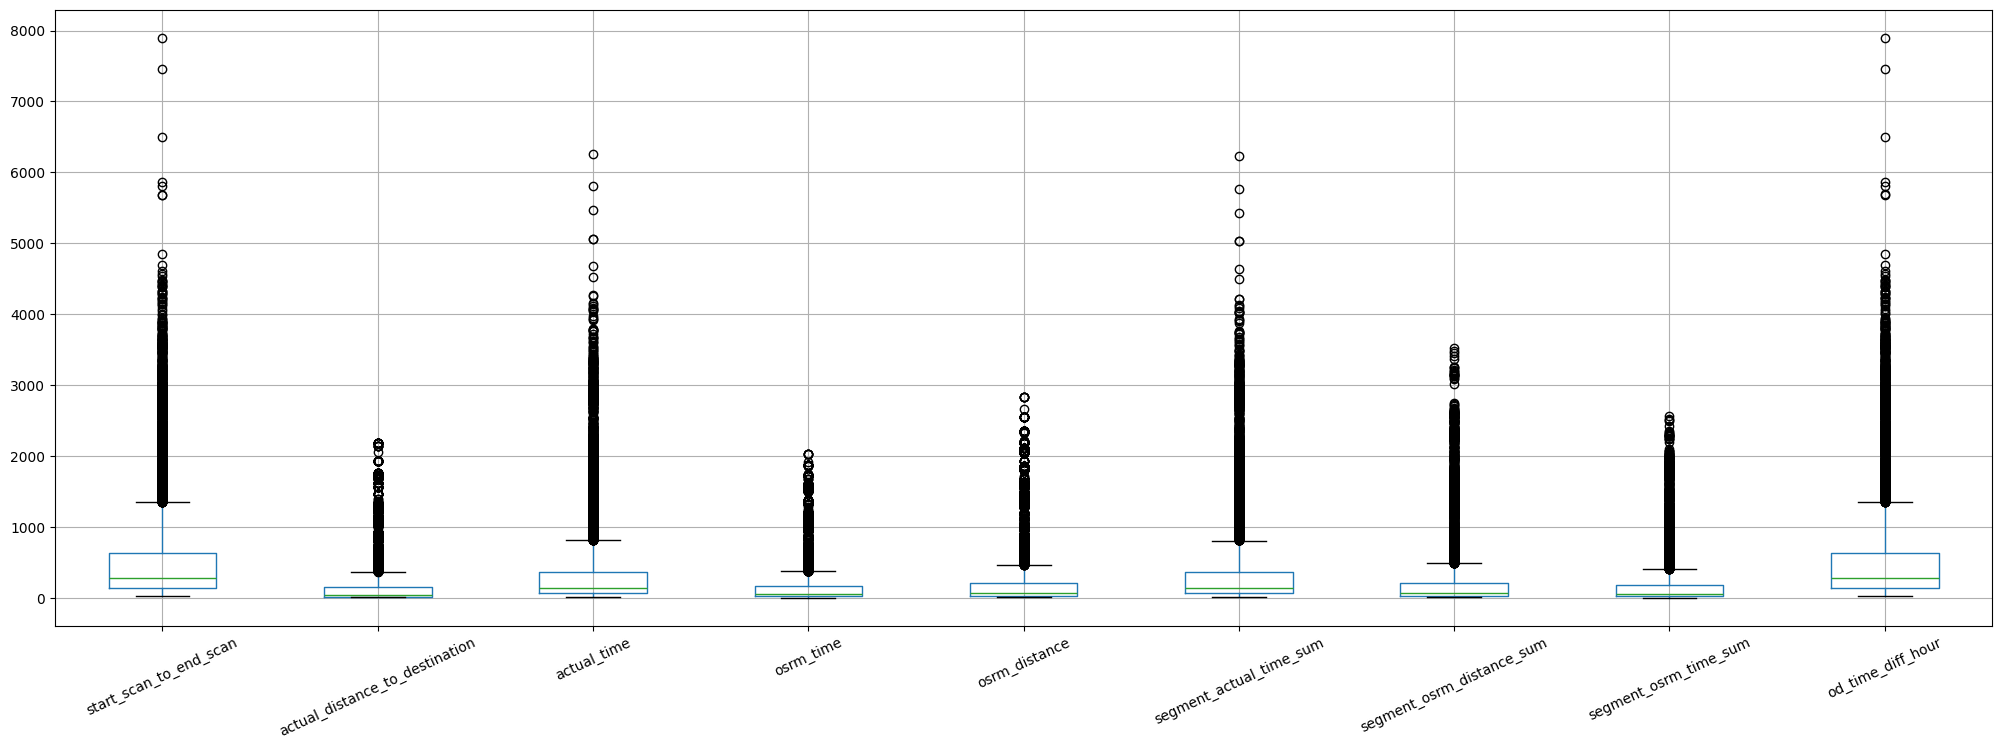

In [35]:
trip[num_cols].boxplot(rot=25, figsize=(25,8))

### Handle the outliers using IQR method

In [36]:
Q1 = trip[num_cols].quantile(0.25)
Q3 = trip[num_cols].quantile(0.75)

IQR = Q3 - Q1

In [37]:
trip = trip[~((trip[num_cols] < (Q1 - 1.5 * IQR)) | (trip[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
trip = trip.reset_index(drop=True)

In [38]:
trip

data         trip_creation_time  \
0      training 2018-09-12 00:00:22.886430   
1      training 2018-09-12 00:01:00.113710   
2      training 2018-09-12 00:02:09.740725   
3      training 2018-09-12 00:02:34.161600   
4      training 2018-09-12 00:04:22.011653   
...         ...                        ...   
12718      test 2018-10-03 23:55:56.258533   
12719      test 2018-10-03 23:57:23.863155   
12720      test 2018-10-03 23:57:44.429324   
12721      test 2018-10-03 23:59:14.390954   
12722      test 2018-10-03 23:59:42.701692   

                                     route_schedule_uuid route_type  \
0      thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...    Carting   
1      thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...    Carting   
2      thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...        FTL   
3      thanos::sroute:9bf03170-d0a2-4a3f-aa4d-9aaab3d...    Carting   
4      thanos::sroute:a97698cc-846e-41a7-916b-88b1741...    Carting   
...                                                  ...        ...   
12718  thanos::sroute:8a120994-f577-4491-9e4b-b7e4a14...    Carting   
12719  thanos::sroute:b30e1ec3-3bfa-4bd2-a7fb-3b75769...    Carting   
12720  thanos::sroute:5609c268-e436-4e0a-8180-3db4a74...    Carting   
12721  thanos::sroute:c5f2ba2c-8486-4940-8af6-d1d2a6a...    Carting   
12722  thanos::sroute:412fea14-6d1f-4222-8a5f-a517042...        FTL   

                     trip_uuid source_center  \
0      trip-153671042288605164  IND561203AAB   
1      trip-153671046011330457  IND400072AAB   
2      trip-153671052974046625  IND583101AAA   
3      trip-153671055416136166  IND600056AAA   
4      trip-153671066201138152  IND600044AAD   
...                        ...           ...   
12718  trip-153861095625827784  IND160002AAC   
12719  trip-153861104386292051  IND121004AAB   
12720  trip-153861106442901555  IND208006AAA   
12721  trip-153861115439069069  IND627005AAA   
12722  trip-153861118270144424  IND583119AAA   

                               source_name destination_center  \
0        doddablpur_chikadpp_d (karnataka)       IND561203AAB   
1                 mumbai hub (maharashtra)       IND401104AAA   
2                   bellary_dc (karnataka)       IND583119AAA   
3         chennai_poonamallee (tamil nadu)       IND600056AAA   
4        chennai_chrompet_dpc (tamil nadu)       IND600048AAA   
...                                    ...                ...   
12718       chandigarh_mehmdpur_h (punjab)       IND160002AAC   
12719         fbd_balabhgarh_dpc (haryana)       IND121004AAA   
12720   kanpur_govndngr_dc (uttar pradesh)       IND208006AAA   
12721  tirunelveli_vdkkusrt_i (tamil nadu)       IND628204AAA   
12722        sandur_wrdn1dpp_d (karnataka)       IND583119AAA   

                         destination_name  start_scan_to_end_scan  ...  \
0       doddablpur_chikadpp_d (karnataka)                   180.0  ...   
1          mumbai_mirard_ip (maharashtra)                   100.0  ...   
2           sandur_wrdn1dpp_d (karnataka)                   717.0  ...   
3        chennai_poonamallee (tamil nadu)                   189.0  ...   
4        chennai_vandalur_dc (tamil nadu)                    98.0  ...   
...                                   ...                     ...  ...   
12718      chandigarh_mehmdpur_h (punjab)                   257.0  ...   
12719      faridabad_blbgarh_dc (haryana)                    60.0  ...   
12720  kanpur_govndngr_dc (uttar pradesh)                   421.0  ...   
12721  tirchchndr_shnmgprm_d (tamil nadu)                   347.0  ...   
12722       sandur_wrdn1dpp_d (karnataka)                   353.0  ...   

        source_state  source_city  source_place  source_code  trip_year  \
0          karnataka   doddablpur      chikadpp            d       2018   
1        maharashtra   mumbai hub        mumbai         none       2018   
2          karnataka      bellary       bellary         none       2018   
3         tamil nadu      chennai       chennai         no

<Axes: >

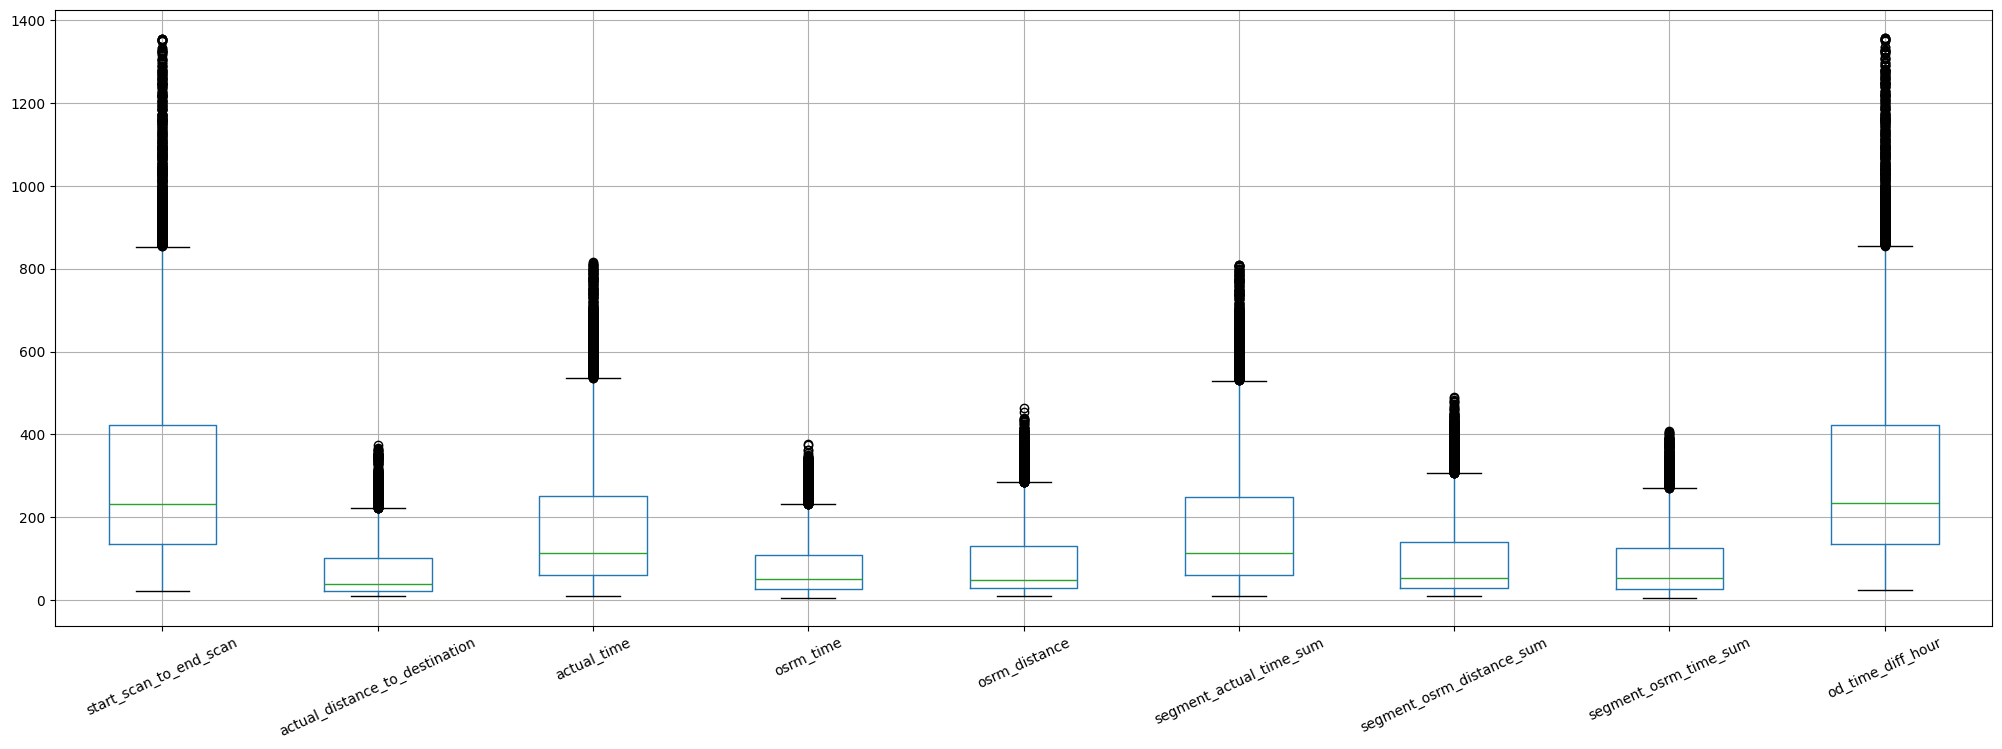

In [39]:
trip[num_cols].boxplot(rot=25, figsize=(25,8))

# Handling Categorical Variables

### Only two route_type – Do one hot encoding

In [40]:
trip['route_type'].value_counts()

route_type
Carting    8812
FTL        3911
Name: count, dtype: int64

In [41]:
trip['route_type'] = trip['route_type'].map({'FTL':0, 'Carting':1})

### Normalize/ Standardize the numerical features using MinMaxScaler or StandardScaler

In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()
scaler.fit(trip[num_cols])

StandardScaler()

In [44]:
trip[num_cols] = scaler.transform(trip[num_cols])

In [45]:
trip[num_cols]

start_scan_to_end_scan  actual_distance_to_destination  actual_time  \
0                   -0.548546                        0.012060    -0.217856   
1                   -0.861602                       -0.765152    -0.749015   
2                    1.552838                        0.764988     1.034163   
3                   -0.513328                       -0.662169    -0.736369   
4                   -0.869428                       -0.877197    -0.970332   
...                       ...                             ...          ...   
12718               -0.247231                       -0.201970    -0.597255   
12719               -1.018130                       -0.788207    -0.989302   
12720                0.394533                       -0.466688     0.661086   
12721                0.104957                        0.865940     0.547267   
12722                0.128436                       -0.086534     0.616823   

       osrm_time  osrm_distance  segment_actual_time_sum  \
0      -0.144341      -0.073948                -0.221500   
1      -0.877085      -0.804506                -0.743482   
2       0.533102       0.614738                 1.045260   
3      -0.766482      -0.710888                -0.737116   
4      -0.904736      -0.890050                -0.966279   
...          ...            ...                      ...   
12718  -0.227293      -0.204002                -0.597073   
12719  -0.918561      -0.844610                -0.985376   
12720  -0.420848      -0.366561                 0.669688   
12721   1.390274       0.886261                 0.523279   
12722  -0.144341      -0.124553                 0.625129   

       segment_osrm_distance_sum  segment_osrm_time_sum  od_time_diff_hour  
0                      -0.145358              -0.262662          -0.544839  
1                      -0.823653              -0.878225          -0.861856  
2                       0.514899               0.365464           1.552812  
3                      -0.737295              -0.790288          -0.510150  
4                      -0.906532              -0.915913          -0.871585  
...                          ...                    ...                ...  
12718                  -0.349273              -0.300349          -0.246189  
12719                  -0.863608              -0.941038          -1.017809  
12720                   0.072932               0.026276           0.395103  
12721                   1.324267               1.697092           0.107436  
12722                  -0.183439              -0.237537           0.130473  

[12723 rows x 9 columns]

In [46]:
trip[num_cols].describe()

start_scan_to_end_scan  actual_distance_to_destination   actual_time  \
count            1.272300e+04                    1.272300e+04  1.272300e+04   
mean            -1.619566e-17                   -7.371818e-17 -8.041983e-17   
std              1.000039e+00                    1.000039e+00  1.000039e+00   
min             -1.162918e+00                   -8.785574e-01 -1.065181e+00   
25%             -7.207269e-01                   -7.065920e-01 -7.363685e-01   
50%             -3.411472e-01                   -4.689012e-01 -4.012322e-01   
75%              4.023595e-01                    4.073375e-01  4.650634e-01   
max              4.049455e+00                    4.178358e+00  4.031419e+00   

          osrm_time  osrm_distance  segment_actual_time_sum  \
count  1.272300e+04   1.272300e+04             1.272300e+04   
mean   4.467769e-17   3.797603e-17            -3.127438e-17   
std    1.000039e+00   1.000039e+00             1.000039e+00   
min   -1.001514e+00  -9.229378e-01            -1.061764e+00   
25%   -7.111809e-01  -7.077649e-01            -7.371165e-01   
50%   -3.931975e-01  -4.836339e-01            -3.997380e-01   
75%    4.224989e-01   4.419548e-01             4.596223e-01   
max    4.113871e+00   4.150641e+00             4.037107e+00   

       segment_osrm_distance_sum  segment_osrm_time_sum  od_time_diff_hour  
count               1.272300e+04           1.272300e+04       1.272300e+04  
mean               -8.488760e-17           6.031487e-17       7.818595e-18  
std                 1.000039e+00           1.000039e+00       1.000039e+00  
min                -9.375981e-01          -1.003850e+00      -1.162915e+00  
25%                -7.228116e-01          -7.274750e-01      -7.210516e-01  
50%                -4.628077e-01          -4.134119e-01      -3.418602e-01  
75%                 4.488499e-01           4.910897e-01       4.020802e-01  
max                 4.130135e+00           4.046283e+00       4.050310e+00

# Trying to predict `actual_time` from other features using stacked Xgboost and RandomForest

In [47]:
df=trip[cols]
Train,test=df.loc[df.data=='training'],df.loc[df.data=='test']

X_train=Train[['actual_distance_to_destination','osrm_time','osrm_distance','segment_osrm_time_sum','segment_osrm_distance_sum','trip_month', 'trip_hour', 'trip_day', 'trip_week', 'trip_dayofweek']]
X_test=test[['actual_distance_to_destination','osrm_time','osrm_distance','segment_osrm_time_sum','segment_osrm_distance_sum','trip_month', 'trip_hour', 'trip_day', 'trip_week', 'trip_dayofweek']]
y_train=Train['actual_time']
y_test=test['actual_time']

## Rf hypertune

In [48]:
%%capture
'''rf_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=95)

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=25, 
    cv=3,  
    n_jobs=-1, 
    scoring='neg_mean_squared_error',
    random_state=95
)

rf_random_search.fit(X_train, y_train)

best_rf_params = rf_random_search.best_params_
best_rf_model = rf_random_search.best_estimator_
'''

In [52]:
#Hypertuned
best_rf_params={'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 40, 'bootstrap': True}
print("Best RandomForestRegressor parameters:", best_rf_params)

Best RandomForestRegressor parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 40, 'bootstrap': True}


## Xgb hypertune

In [49]:
%%capture
'''xgb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 9, 12],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=95)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=25, 
    cv=3,  
    n_jobs=-1, 
    scoring='neg_mean_squared_error',
    random_state=95
)

xgb_random_search.fit(X_train, y_train)

best_xgb_params = xgb_random_search.best_params_
best_xgb_model = xgb_random_search.best_estimator_
'''

In [51]:
#Hypertuned
best_xgb_params={'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
print("Best XGBRegressor parameters:", best_xgb_params)

Best XGBRegressor parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [56]:
base_models = [
    ('rf', RandomForestRegressor(**best_rf_params)),
    ('xgb', XGBRegressor(**best_xgb_params))
]

meta_model = Ridge()
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
)
stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {np.sqrt(mse):.4f}")
print(f"R^2: {stacking_regressor.score(X_test,y_test)}")

Mean Squared Error: 0.4712
R^2: 0.7658266336351892


### RMSE is .47 which is quite less so its good.
### R^2 is .77 which is also quite good.

## Recomendations:

- Osrm routing consistency should be checked as distance is significantly more whereas time is less.


- North, South and West Zones corridors have significant traffic of orders. But, we have a smaller presence in Central, Eastern and North-Eastern zone. However it would be difficult to conclude this, by looking at just 2 months data. It is worth investigating and increasing our presence in these regions.


- From state point of view, we have heavy traffic in Mahrashtra followed by Karnataka. This is a good indicator that we need to plan for resources on ground in these 2 states on priority. Especially, during festive seasons.


- Use the regressor with proper data to get predicted actual time of delivery.